<a href="https://colab.research.google.com/github/skywalker0803r/oil_web/blob/master/%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90_modeling%E6%B5%81%E7%A8%8B_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install catboost
from google.colab import drive
drive.mount('/content/drive')
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import warnings;warnings.simplefilter('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import BayesianRidge, LinearRegression,Lasso,Ridge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,max_error,make_scorer
from math import sqrt
from sklearn.manifold import isomap
from numpy import sqrt
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# some function

In [0]:
def mape(a, b):
    a = np.array(a)
    b = np.array(b)
    mask = a != 0
    return (np.fabs(a-b)/a)[mask].mean()

def metric(y_t,y_p,name):
  res = {'R2' : max(r2_score(y_t,y_p), 0),
         'RMSE': sqrt(mean_squared_error(y_t,y_p)),
         'MAPE': mape(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

# load data

In [3]:
data = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0)
train = data.loc[data.index %5 != 0]
test = data.loc[data.index %5 == 0]
test = test.drop(95,axis=0)
print(train.shape)
print(test.shape)

(200, 31)
(49, 31)


# select N+A >= 36

In [4]:
def select_NaddA(df):
  condition=(df['N+A']>=36)
  return df.loc[condition]
train = select_NaddA(train)
test = select_NaddA(test)
print(train.shape)
print(test.shape)

(182, 31)
(43, 31)


# 定義欄位

In [0]:
features = ['T10','T50','T90','N+A']
y_columns = ['C5NP', 'C5IP', 'C5N', 
             'C6NP', 'C6IP', 'C6N', 'C6A', 
             'C7NP', 'C7IP', 'C7N', 'C7A', 
             'C8NP', 'C8IP', 'C8N', 'C8A', 
             'C9NP', 'C9IP', 'C9N', 'C9A', 
             'C10NP', 'C10IP', 'C10N', 'C10A']

In [6]:
train = train[features+y_columns]
test = test[features+y_columns]
print(train.shape)
print(test.shape)

(182, 27)
(43, 27)


# gau

In [7]:
full = train.append(test)
gau = GaussianMixture(n_components=3)
gau.fit(full)
full['gau'] = gau.predict(full)
train = full[:200]
test = full[200:]
print(full.gau.value_counts())

0    152
1     40
2     33
Name: gau, dtype: int64


# 定義x,y

In [0]:
features.append('gau')
X_train = train[features]
X_test = test[features]
y_train = train[y_columns]
y_test = test[y_columns]

# 特徵縮放

In [0]:
#scaler_x = StandardScaler()
#X_train[:] = scaler_x.fit_transform(X_train[:])
#X_test[:] = scaler_x.transform(X_test[:])

# 降維萃取特徵

In [0]:
#for i,t in zip(['iso1','iso2','iso3'],['T10','T50','T90']):
#  iso = isomap.Isomap(n_components=1)
#  X_train[i] = iso.fit_transform(X_train[[t,'N+A']]) 
#  X_test[i] = iso.transform(X_test[[t,'N+A']]) 

# 產生溫差特徵

In [0]:
#for df in [X_train,X_test]:
#  df['T90-T50'] = df['T90']-df['T50']
#  df['T50-T10'] = df['T50']-df['T10']
#  df['T90-T10'] = df['T90']-df['T10']

# 平方特徵

In [0]:
#for df in [X_train,X_test]:
#  df['T10_s2'] = df['T10']**2
#  df['T50_s2'] = df['T50']**2
#  df['T90_s2'] = df['T90']**2
#  df['N+A_s2'] = df['N+A']**2

# 產生交互作用項

In [0]:
#from sklearn.preprocessing import PolynomialFeatures
#interaction = PolynomialFeatures(2, interaction_only=True, include_bias=False)
#X_train = interaction.fit_transform(X_train)
#X_train = pd.DataFrame(X_train,columns=interaction.get_feature_names())
#X_test = interaction.transform(X_test)
#X_test = pd.DataFrame(X_test,columns=interaction.get_feature_names())

# 特徵篩選

In [0]:
features = X_train.columns.tolist()
train = X_train.join(y_train)
test = X_test.join(y_test)
full = train.append(test)

def features_selected():
  features_map = {}
  for y_name in y_columns:
    best_feature = abs(full.corr(method='pearson')).loc[features,[y_name]].sort_values(by=y_name,ascending=False).index.tolist()[1:2]
    if best_feature not in ['T10','T50','T90','N+A']:
      features_map[y_name] =  ['T10','T50','T90','N+A'] + best_feature
    else:
      features_map[y_name] =  ['T10','T50','T90','N+A']
    features_map[y_name] =  ['T10','T50','T90','N+A','gau']
  return features_map

In [15]:
features_map = features_selected()
res = pd.DataFrame()
for y_name in y_columns:
  res.loc[y_name,'features'] = str(features_map[y_name])
res

,features
C5NP,"['T10', 'T50', 'T90', 'N+A', 'gau']"
C5IP,"['T10', 'T50', 'T90', 'N+A', 'gau']"
C5N,"['T10', 'T50', 'T90', 'N+A', 'gau']"
C6NP,"['T10', 'T50', 'T90', 'N+A', 'gau']"
C6IP,"['T10', 'T50', 'T90', 'N+A', 'gau']"
C6N,"['T10', 'T50', 'T90', 'N+A', 'gau']"
C6A,"['T10', 'T50', 'T90', 'N+A', 'gau']"
C7NP,"['T10', 'T50', 'T90', 'N+A', 'gau']"
C7IP,"['T10', 'T50', 'T90', 'N+A', 'gau']"
C7N,"['T10', 'T50', 'T90', 'N+A', 'gau']"


# models

In [0]:
svr = Pipeline([('scaler',StandardScaler()),('regressor',SVR(C=15))])
cgb = CatBoostRegressor(n_estimators = 100,learning_rate = 0.1,verbose=False)
lr = Pipeline([('scaler',StandardScaler()),('regressor',LinearRegression())])
ridge = Pipeline([('scaler',StandardScaler()),('regressor',Ridge())])

# define model

# 測試

In [17]:
y_train_pred = pd.DataFrame(index = y_train.index,columns = y_columns)
y_pred = pd.DataFrame(index = y_test.index,columns = y_columns)

for y_name in y_columns:
  
  model = cgb
  model.fit(X_train[features_map[y_name]].values,y_train[y_name].values)

  y_train_pred[y_name] = model.predict(X_train[features_map[y_name]].values)
  y_pred[y_name] = model.predict(X_test[features_map[y_name]].values)

y_pred.head()  

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
120,1.641890,1.057666,0.313020,3.104367,3.003040,6.194348,0.542752,5.236287,4.547948,18.709633,3.952896,6.999171,9.582560,9.338747,5.944836,3.861792,5.721447,4.083445,2.356433,1.033167,2.306894,0.385406,0.618350
125,1.807722,1.069676,0.330051,3.197231,3.095727,6.256499,0.527394,5.317145,4.491426,18.306230,3.604501,6.293094,9.360252,9.036276,5.245386,3.832512,5.644549,4.143022,2.479435,1.636212,2.845714,0.527149,1.137058
130,1.865228,1.136984,0.344121,3.122419,3.110165,6.205473,0.559952,5.299866,4.528448,18.706156,3.527170,6.072341,9.204695,9.140946,5.106274,3.822861,5.741507,4.180721,2.452160,1.383449,2.818178,0.480092,0.992397
135,0.949798,0.748726,0.216311,2.741838,2.335519,5.121142,0.595968,4.985652,4.775285,14.668557,4.043913,6.312032,8.671196,9.946124,5.904767,4.372643,7.586125,5.432854,3.387687,1.259632,3.840337,0.578751,0.986120
140,0.412194,0.240477,0.061396,0.951798,0.904522,5.673874,0.675749,6.553102,8.022211,26.574359,5.459215,5.084544,8.144873,9.200193,4.915230,2.152194,6.132764,4.235815,1.674051,0.524549,2.028791,0.425316,0.685395


In [18]:
res = pd.DataFrame()
for y_name in y_columns:
  res = res.append(metric(y_train[y_name],y_train_pred[y_name],y_name))
res.loc['AVG'] = res.mean()
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.991939,0.358683,0.925357
C5IP,0.991476,0.279912,1.12533
C5N,0.988554,0.0360244,0.262956
C6NP,0.979241,0.293099,0.246605
C6IP,0.988484,0.287278,0.339216
C6N,0.955935,0.428502,0.0662054
C6A,0.957026,0.262956,0.361498
C7NP,0.927854,0.283147,0.0387101
C7IP,0.941313,0.360411,0.0470493
C7N,0.973435,0.920669,0.0502708


In [19]:
res = pd.DataFrame()
for y_name in y_columns:
  res = res.append(metric(y_test[y_name],y_pred[y_name],y_name))
res.loc['AVG'] = res.mean()
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.91551,0.580197,0.178511
C5IP,0.942896,0.251712,0.152072
C5N,0.885381,0.0514957,0.160309
C6NP,0.871724,0.462486,0.217421
C6IP,0.841243,0.530455,0.167883
C6N,0.687507,1.31095,0.207667
C6A,0.0287173,0.206749,0.474843
C7NP,0.729185,0.333373,0.0432135
C7IP,0.900337,0.51935,0.0624674
C7N,0.876414,1.59031,0.061148


# loss analysis

In [0]:
y_name = 'C7N'

In [21]:
square_error = (y_pred[y_name]-y_test[y_name])**2
plot_data = pd.DataFrame()
plot_data[y_name] = y_test[y_name]
plot_data[y_name+'_pred'] = y_pred[y_name]
plot_data['loss'] = square_error
plot_data.sort_values(by='loss',ascending=False).head()

,C7N,C7N_pred,loss
145,17.906555,13.575891,18.754649
135,18.577741,14.668557,15.281721
155,17.918637,15.605377,5.351168
200,14.437906,12.394780,4.174365
120,20.558219,18.709633,3.417269


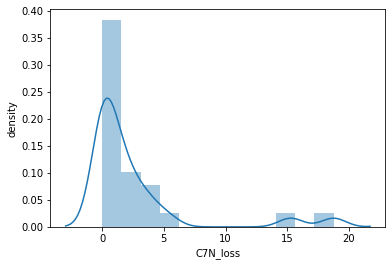

In [22]:
sns.distplot(square_error)
plt.xlabel(y_name+'_loss')
plt.ylabel('density')
plt.show()

Text(0, 0.5, 'square_error')

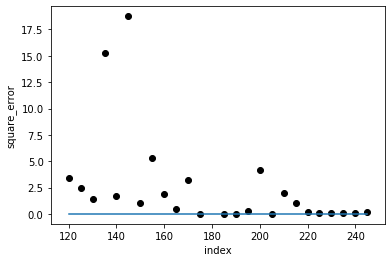

In [23]:
plt.plot(plot_data.index,[0 for i in range(len(plot_data))])
plt.scatter(plot_data.index,plot_data.loss,color='black')
plt.xlabel('index')
plt.ylabel('square_error')